In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

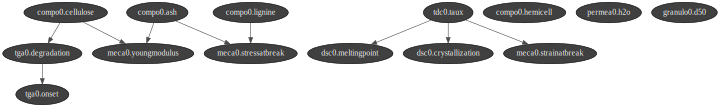

In [2]:
bn = gum.loadBN('BDD/composite_withSystem.o3prm', system = "Ontology")
gnb.showBN(bn, nodeColor = {"meca_0.stressatbreak":0.5, "meca_0.youngmodulus":0.5}, size = 10)

### 1. Target Constraints
Expert give us the wished constraints, which are tranlasted within a new _Target_ node.

In [3]:
cdVar = {"meca0.stressatbreak": [ ["t_2", "t_1"], ["t_0"] ],
         "meca0.youngmodulus": [ ["t_2", "t_1"], ["t_0"] ]}

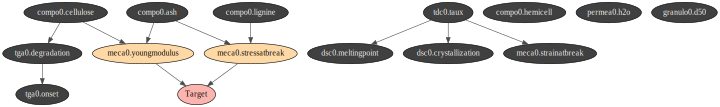

In [4]:
# We add the Target variable
eva = ["Good", "Average", "Bad"]
target = gum.LabelizedVariable("Target", "Target", eva)
bn.add(target)

# We add Target's parents
for p in cdVar.keys():
    bn.addArc(p, "Target")

gnb.showBN(bn, nodeColor = {"Target":0.1, "meca0.stressatbreak":0.5, "meca0.youngmodulus":0.5}, size = 10)

In [5]:
from itertools import product

# For every combination of value we define Target
cible_values = [cdVar[i] for i in cdVar]
for comb in product( *cible_values ):
    # Evaluate the nature of the combination
    note = "Good"
    
    for c in range(len(comb)):
        
        cible = list(cdVar.keys())[c]
        
        if cdVar[cible].index(comb[c]) == len(cdVar[cible])-1:
            note = "Bad"
        elif cdVar[cible].index(comb[c]) != 0 and note != "Bad":
            note = "Average"

    # Attribute the Target's values
    for comb2 in product( *comb ):
        d_cible = { list(cdVar.keys())[i]:comb2[i] for i in range(len(comb2)) }
        
        loi = [ 0 for k in range(len(eva)) ]
        loi[ eva.index(note) ] = 1
        
        bn.cpt("Target")[d_cible] = loi
        
bn.cpt("Target")

(pyAgrum.Potential<double>@0x21ad8995870) 
             ||  Target                     |
meca0.|meca0.||Good     |Average  |Bad      |
------|------||---------|---------|---------|
t_0   |t_0   || 0.0000  | 0.0000  | 1.0000  |
t_1   |t_0   || 0.0000  | 0.0000  | 1.0000  |
t_2   |t_0   || 0.0000  | 0.0000  | 1.0000  |
t_0   |t_1   || 0.0000  | 0.0000  | 1.0000  |
t_1   |t_1   || 1.0000  | 0.0000  | 0.0000  |
t_2   |t_1   || 1.0000  | 0.0000  | 0.0000  |
t_0   |t_2   || 0.0000  | 0.0000  | 1.0000  |
t_1   |t_2   || 1.0000  | 0.0000  | 0.0000  |
t_2   |t_2   || 1.0000  | 0.0000  | 0.0000  |

### 2. Components constraints

We include a physical constraint: the sum of components must be around 100.

In [6]:
import json

with open("BDD/discretisation.txt", "r") as f:
    d_discret = json.loads( f.read() )

compo = ["compo0.ash", "compo0.cellulose", "compo0.hemicell", "compo0.lignine"]
d_compo = { c:[] for c in compo }
for c in compo:
    for k in range(len(d_discret[c].keys())):
        v = d_discret[c][f't_{k}'][1:-1].split(";")
        d_compo[c].append( (float(v[0]), float(v[1])) )

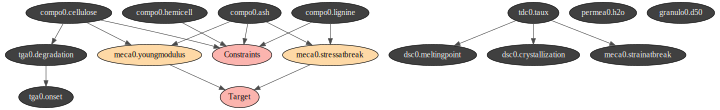

In [7]:
# On ajoute la variable Target
target = gum.LabelizedVariable("Constraints", "Constraints", ["OK", "Not OK"])
bn.add(target)

# On ajoute les parents de Target
for p in compo:
    bn.addArc(p, "Constraints")

gnb.showBN(bn, size = 10, nodeColor = {"Target":0.1, "Constraints":0.1,
                                      "meca0.stressatbreak":0.5, "meca0.youngmodulus":0.5})

In [8]:
for comb in product( *[d_compo[k] for k in compo]):
    # Sum(min(values)) < 100
    # Sum(max(values) > 100)
    
    mini = sum( [k[0] for k in comb] )
    maxi = sum( [k[1] for k in comb] )
    
    if mini<100 :#:and maxi<100:
        loi = [1,0]
    else:
        loi = [0,1]

    # Define parents
    d_parent = {p:"" for p in compo}
    for p in range(len(compo)):
        parent = compo[p]
        d_parent[parent] = d_compo[parent].index(comb[p]) #"t_{}".format( d_compo[parent].index(comb[p]) )

    bn.cpt("Constraints")[d_parent] = loi
    
bn.cpt("Constraints")

(pyAgrum.Potential<double>@0x21ad8995a30) 
                           ||  Constraints      |
compo0|compo0|compo0|compo0||OK       |Not OK   |
------|------|------|------||---------|---------|
t_0   |t_0   |t_0   |t_0   || 1.0000  | 0.0000  |
t_1   |t_0   |t_0   |t_0   || 1.0000  | 0.0000  |
t_2   |t_0   |t_0   |t_0   || 1.0000  | 0.0000  |
t_0   |t_1   |t_0   |t_0   || 1.0000  | 0.0000  |
t_1   |t_1   |t_0   |t_0   || 1.0000  | 0.0000  |
t_2   |t_1   |t_0   |t_0   || 1.0000  | 0.0000  |
[...96 more line(s) ...]
t_0   |t_2   |t_2   |t_2   || 1.0000  | 0.0000  |
t_1   |t_2   |t_2   |t_2   || 1.0000  | 0.0000  |
t_2   |t_2   |t_2   |t_2   || 1.0000  | 0.0000  |
t_0   |t_3   |t_2   |t_2   || 0.0000  | 1.0000  |
t_1   |t_3   |t_2   |t_2   || 0.0000  | 1.0000  |
t_2   |t_3   |t_2   |t_2   || 0.0000  | 1.0000  |